In [2]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f

cheated_0 = Events('CheatedRecoFile_0.root')

# training and testing indices, we have 499617 events in cheated_0
start_training = 0
end_training = 399999
start_testing = 400000
end_testing = 499616

# other variables
cutoff = 20
plots = True


# find some events in the last 100k events that we will use for testing, these are JUST FOR DEMONSTRATION

testing_idx = []

for i in range(start_testing, end_testing + 1):
    n = len(cheated_0.reco_hits_w[i])
    if n > 200: # more than 200 hits, demonstration purposes only
        testing_idx.append(i)


# ROC curve function

def ROC(pdf): # takes a tuple of p_t, p_s as pdf
    p_t = pdf[0]
    p_s = pdf[1]
    eff = []
    pur = []

    for i in range(0, len(p_s)):
        
        shower_right = sum(p_s[i:])
        both_right = sum(p_s[i:]) + sum(p_t[i:])
        shower_all = sum(p_s)

        e = shower_right / shower_all
        
        # Check to avoid division by zero in purity calculation
        if both_right != 0:
            p = shower_right / both_right  # Purity
        else:
            p = 1  # or you could continue to the next iteration with "continue"

        eff.append(e)
        pur.append(p)

    plt.plot(eff, pur)
    plt.scatter(eff, pur, s=15, marker='x')
    plt.scatter(1, 1, c='orange', label="Ideal", s=15, marker='x')
    plt.xlabel("Efficiency")
    plt.ylabel("Purity")
    plt.title("Efficiency vs Purity Curve for picking a shower")
    plt.legend()
    plt.show()

In [ ]:
f.adc_profile_idx(cheated_0, 3788)
f.plot_idx(cheated_0, 3788)
f.adc_profile_idx(cheated_0, 1554)
f.plot_idx(cheated_0, 1554)

In [ ]:
# just fit a linear curve and get the slope to see what happens for events. will go over all events in cheated_0

def adc_slope(events, hits_cutoff, show_plot=False):
    events_size = len(cheated_0.num_final_state_particles) # number of events in the file

    track_slopes = []
    shower_slopes = []
    
    for i in range(0, events_size):
        w_hits = events.reco_hits_w[i]
        adcs = events.reco_adcs_w[i]

        if len(w_hits) > hits_cutoff:
            
            # find slope
            coefficients = np.polyfit(w_hits, adcs, 1)
            slope = coefficients[0]
    
            if events.mc_pdg[i] in [-11, 11, 22]:
                shower_slopes.append(slope)
            else: track_slopes.append(slope)


    # Manually get the fraction
    n_t = len(track_slopes)
    n_s = len(shower_slopes)
    
    bin_edges = np.arange(-300, 301, 5)

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(track_slopes) / n_t if n_t > 0 else np.zeros_like(track_slopes)
    shower_weights = np.ones_like(shower_slopes) / n_s if n_s > 0 else np.zeros_like(shower_slopes)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(track_slopes, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(shower_slopes, bins=bin_edges, weights=shower_weights)
    
    plt.figure(figsize = (12,8))
    plt.hist(track_slopes, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='track slopes')
    plt.hist(shower_slopes, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='shower slopes')
    plt.legend()
    plt.xlim(-130, 130)
    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges

adc_slopes = adc_slope(cheated_0, 15, True)

In [ ]:
f.ROC_alt(adc_slopes)

In [ ]:
# what about little energy packets and seeing where the energy density is highest?

def energy_packets_idx(events, event_idx, num_steps):
    w_pos = events.reco_hits_w[event_idx]
    adcs = events.reco_adcs_w[event_idx]
    points = np.column_stack((w_pos, adcs))

    # find the cuts for which we want to find the energies at
    steps = np.linspace(min(w_pos), max(w_pos), num_steps + 1)

    avg_adc = []

    for s in range(len(steps) - 1):
        # Define the current interval
        start, end = steps[s], steps[s + 1]
        
        # Select the y-values within the current interval
        mask = (points[:, 0] >= start) & (points[:, 0] < end)
        y_values_in_interval = points[mask, 1]
        
        # Compute the average y-value for the interval if there are points in it
        if len(y_values_in_interval) > 0:
            average_y = np.mean(y_values_in_interval)
        else:
            average_y = np.nan  # Handle case with no points in the interval
        
        # Append the average to the list
        avg_adc.append(average_y)

    midpoints = (steps[:-1] + steps[1:]) / 2
    
    plt.scatter(w_pos, adcs, c='g', s=3, alpha=0.3, label='ADC profile')
    plt.plot(midpoints, avg_adc, c='r', label='Energy density approximation')

energy_packets_idx(cheated_0, 3788, 50) # 50 sections

In [ ]:
def adc_max(events, event_idx, num_steps):
    w_pos = events.reco_hits_w[event_idx]
    adcs = events.reco_adcs_w[event_idx]
    points = np.column_stack((w_pos, adcs))

    # find the boundaries for which we want to find the energies at
    steps = np.linspace(min(w_pos), max(w_pos), num_steps + 1)
    midpoints = (steps[:-1] + steps[1:]) / 2

    avg_adc = []

    for s in range(len(steps) - 1):
        # Define the current interval
        start, end = steps[s], steps[s + 1]
        
        # Select the y-values within the current interval
        mask = (points[:, 0] >= start) & (points[:, 0] < end)
        y_values_in_interval = points[mask, 1]
        
        # Compute the average y-value for the interval if there are points in it
        if len(y_values_in_interval) > 0:
            average_y = np.mean(y_values_in_interval)
        else:
            average_y = np.nan  # Handle case with no points in the interval
        
        # Append the average to the list
        avg_adc.append(average_y)

    max_idx = np.argmax(avg_adc)
    location = (midpoints[max_idx] - min(steps))/(max(steps) - min(steps)) # standardise to [0,1]
    return location


def var_adc_max1(events, hits_cutoff, num_steps, show_plot):
    event_size = len(events.num_final_state_particles)

    peak_track = []
    peak_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:
            location = adc_max(events, i, num_steps)
    
            if events.mc_pdg[i] in [-11,11,22]:
                peak_shower.append(location)
            else: peak_track.append(location)

    bin_edges = np.linspace(0, 1, num_steps + 1)

    n_t = len(peak_track)
    n_s = len(peak_shower)

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(peak_track) / n_t if n_t > 0 else np.zeros_like(peak_track)
    shower_weights = np.ones_like(peak_shower) / n_s if n_s > 0 else np.zeros_like(peak_shower)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(peak_track, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(peak_shower, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(peak_track, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='Tracks')
    plt.hist(peak_shower, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='Showers')

    # Set plot details
    plt.title(f'Fractional Histogram of {n_t + n_s} ADC Peak Values for events above {hits_cutoff} hits, {n_t} tracks and {n_s} showers.')
    plt.xlabel('Peak Value')
    plt.ylabel('Fraction of events')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlim(0,1)
    plt.legend()
    plt.grid(False)
    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges

adc_pdf = var_adc_max1(cheated_0, 15, 8, True)

In [ ]:
def p_adc(training_data, testing_events, event_idx): # training_data ss a tuple of arrays: track_bin_heights, shower_bin_heights; testing events: an events class; event_idx as usual
    pdf_t, pdf_s, bin_edges = training_data

    val = adc_max(testing_events, event_idx, 4)

    p_idx = np.searchsorted(bin_edges, val) - 1

    if p_idx < 0 or p_idx > max(bin_edges):
        return 0,0
    
    p_t = pdf_t[p_idx]
    p_s = pdf_s[p_idx]

    return p_t, p_s

cheated_10 = Events("CheatedRecoFile_10.root")

p1 = p_adc(adc_pdf, cheated_10, 3011) # example, definite shower
print(f'Probability of track, shower: {p1}')
L_shower = p1[1]/(p1[0] + p1[1])
L_track = p1[0]/(p1[0] + p1[1])

print(f'Likelihood of a track: {L_track}')
print(f'Likelihood of a shower: {L_shower}')

f.plot_idx(cheated_10, 3011)

In [ ]:
f.adc_profile_idx(cheated_10, 3011)

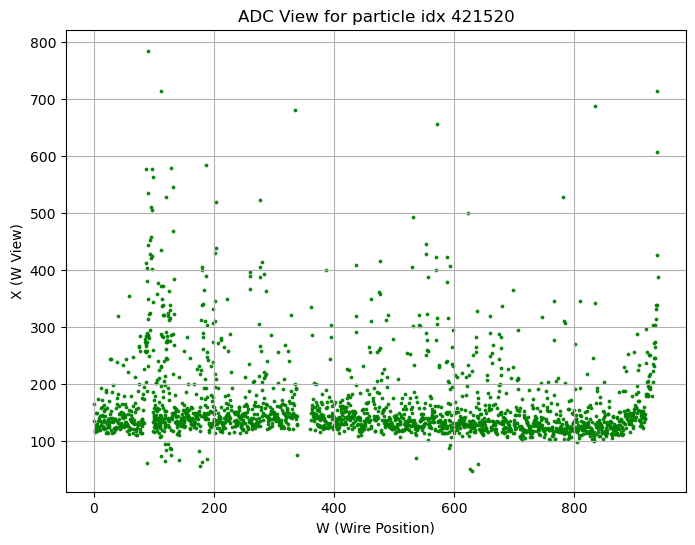

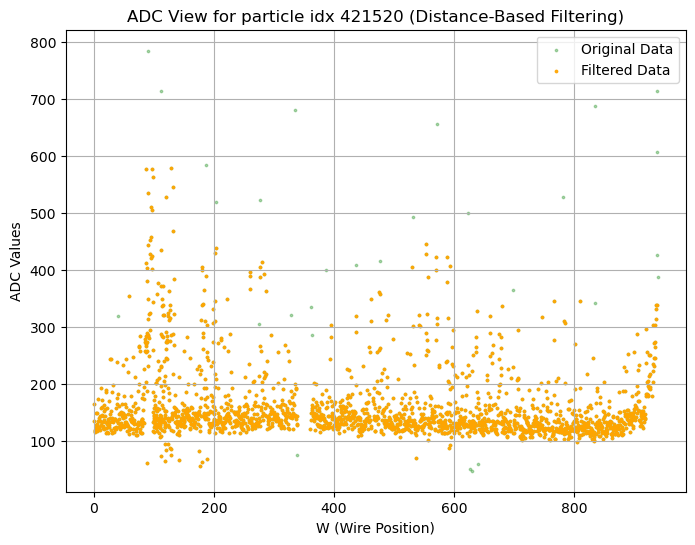

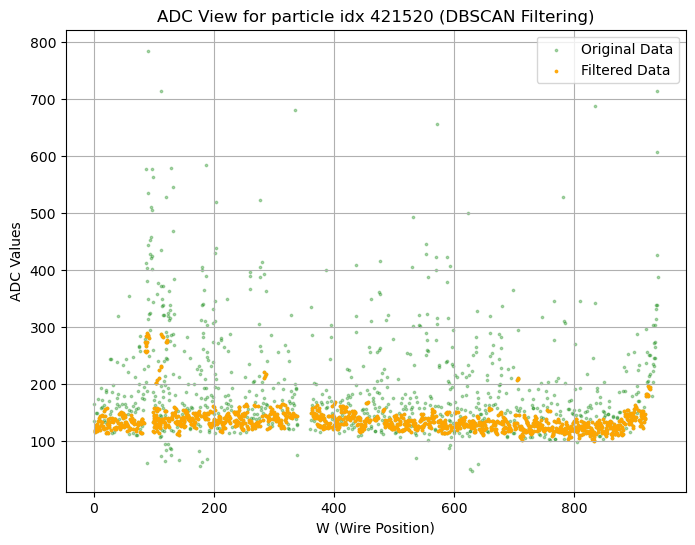

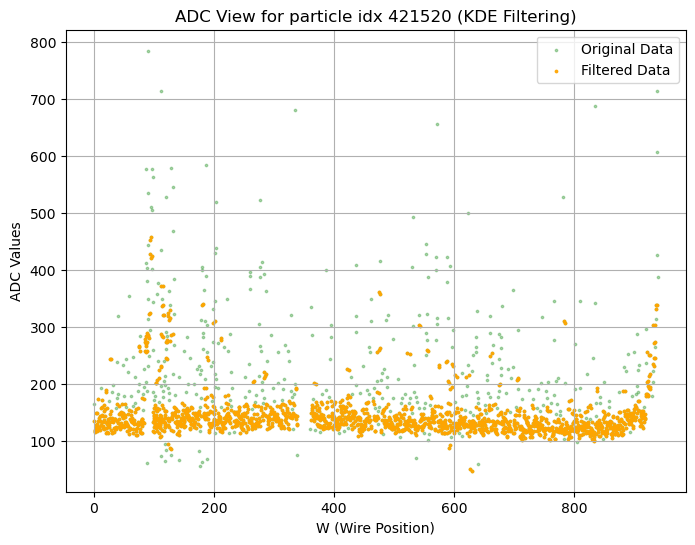

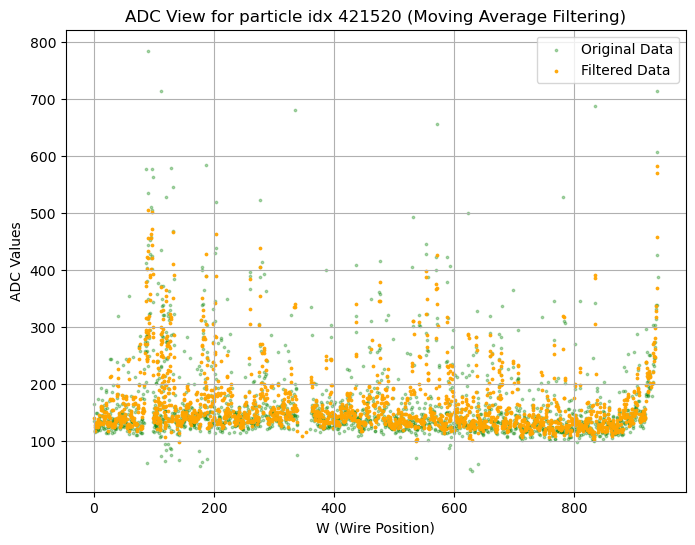

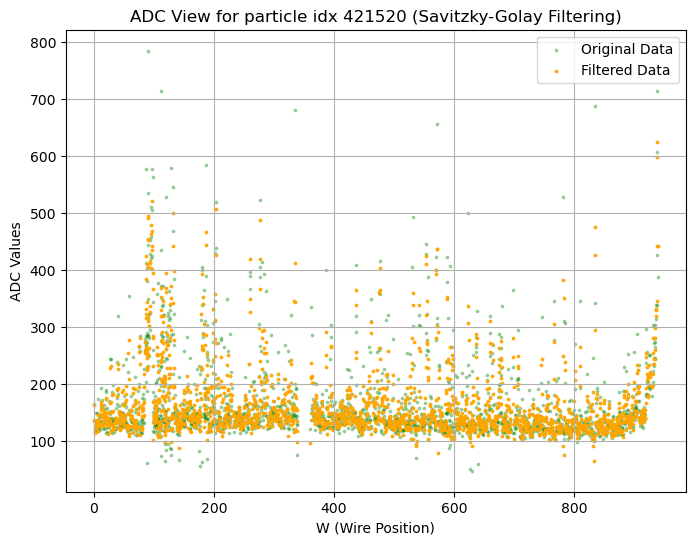

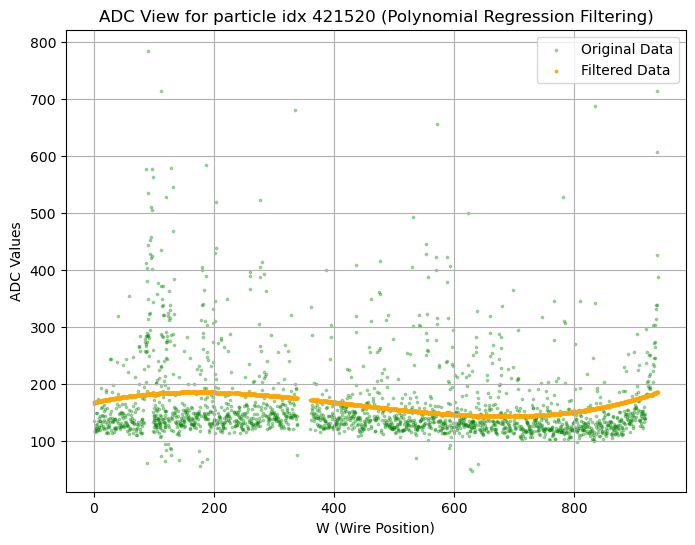

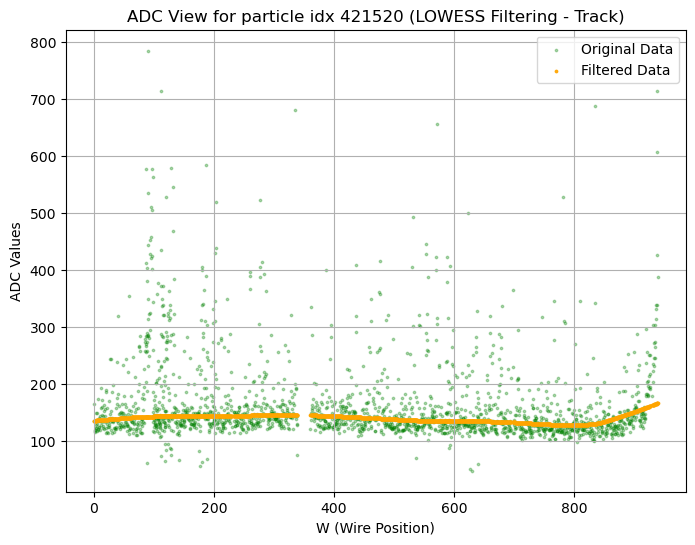

(array([5.98249972e-01, 1.07725000e+00, 1.55624998e+00, ...,
        9.38301270e+02, 9.38780273e+02, 9.39259277e+02]),
 array([135.83425901, 135.87779524, 135.9213052 , ..., 166.2914359 ,
        166.49469667, 166.69831213]))

In [3]:
# use 7 methods of noise filtering for energy deposition...

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.signal import savgol_filter
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_filtered(w_hits, adc_values, w_filtered, adc_filtered, event_idx, method_name=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(w_hits, adc_values, c='g', s=3, alpha=0.3, label='Original Data')
    plt.scatter(w_filtered, adc_filtered, c='orange', s=3, alpha=0.9, label='Filtered Data')
    plt.title(f'ADC View for particle idx {event_idx} ({method_name})')
    plt.ylabel('ADC Values')
    plt.xlabel('W (Wire Position)')
    plt.grid(True)
    plt.legend()
    plt.show()


def adc_profile_idx_filtered_1(events, event_idx, show_plot=False):
    # Extract hits and ADC values for a single event
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]

    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')

    # Distance-based filtering
    distance_threshold = 0.05 * (max(w_hits) - min(w_hits))  # Maximum distance for a neighbor to be "close", choose 5% of event size
    min_neighbors = 3         # Minimum number of close neighbors for a point to be retained

    # Combine w_hits and adc_values into a 2D array for distance calculations
    data = np.vstack((w_hits, adc_values)).T
    distances = squareform(pdist(data))  # Pairwise distances between points
    neighbor_count = (distances < distance_threshold).sum(axis=1) - 1  # Exclude the point itself

    # Create a mask for points with enough close neighbors
    mask = neighbor_count >= min_neighbors

    # Filter w_hits and adc_values
    w_filtered = w_hits[mask]
    adc_filtered = adc_values[mask]

    # Plot the filtered data
    if show_plot:
        plot_filtered(w_hits, adc_values, w_filtered, adc_filtered, event_idx, 'Distance-Based Filtering')

    return w_filtered, adc_filtered



def adc_profile_idx_filtered_2(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    data = np.vstack((w_hits, adc_values)).T
    dbscan = DBSCAN(eps=5.0, min_samples=3)
    labels = dbscan.fit_predict(data)
    mask = labels != -1  # Filter out noise (label = -1)
    
    w_filtered = w_hits[mask]
    adc_filtered = adc_values[mask]
    plot_filtered(w_hits, adc_values, w_filtered, adc_filtered, event_idx, 'DBSCAN Filtering')


def adc_profile_idx_filtered_3(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    data = np.vstack((w_hits, adc_values)).T
    kde = KernelDensity(bandwidth=2.0).fit(data)
    scores = kde.score_samples(data)
    threshold = np.percentile(scores, 20)  # Keep top 80% of density scores
    mask = scores >= threshold
    
    w_filtered = w_hits[mask]
    adc_filtered = adc_values[mask]
    if show_plot:
        plot_filtered(w_hits, adc_values, w_filtered, adc_filtered, event_idx, 'KDE Filtering')

    return w_filtered, adc_filtered


def adc_profile_idx_filtered_4(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    window_size = 3
    adc_smooth = np.convolve(adc_values, np.ones(window_size)/window_size, mode='valid')
    w_smooth = np.convolve(w_hits, np.ones(window_size)/window_size, mode='valid')
    
    plot_filtered(w_hits, adc_values, w_smooth, adc_smooth, event_idx, 'Moving Average Filtering')


def adc_profile_idx_filtered_5(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    adc_smooth = savgol_filter(adc_values, window_length=5, polyorder=2)
    plot_filtered(w_hits, adc_values, w_hits, adc_smooth, event_idx, 'Savitzky-Golay Filtering')


from numpy.polynomial.polynomial import Polynomial

def adc_profile_idx_filtered_6(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    degree = 3
    poly = Polynomial.fit(w_hits, adc_values, degree)
    adc_smooth = poly(w_hits)
    
    plot_filtered(w_hits, adc_values, w_hits, adc_smooth, event_idx, 'Polynomial Regression Filtering')


def adc_profile_idx_filtered_7(events, event_idx, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]
    adc_values = events.reco_adcs_w[event_idx]
    if len(w_hits) <= 5:
        return print('Less than 5 hits in event, not sufficient to plot.')
    
    frac = 0.2  # Fraction of data to use for smoothing
    smoothed = lowess(adc_values, w_hits, frac=frac)
    w_smooth, adc_smooth = smoothed[:, 0], smoothed[:, 1]

    if show_plot:
        if events.mc_pdg[event_idx] in [-11, 11, 22]:
            plot_filtered(w_hits, adc_values, w_smooth, adc_smooth, event_idx, 'LOWESS Filtering - Shower')
        else: plot_filtered(w_hits, adc_values, w_smooth, adc_smooth, event_idx, 'LOWESS Filtering - Track')

    return w_smooth, adc_smooth
    

sample_array = []

for i in range(len(cheated_0.reco_hits_w)):
    if len(cheated_0.reco_hits_w[i]) > 1500:
        sample_array.append(i)

# get a sample index
import random
sample_idx = random.choice(sample_array)

# plot the sample...
f.adc_profile_idx(cheated_0, sample_idx)

# plot the different filtering methods
adc_profile_idx_filtered_1(cheated_0, sample_idx, True)  # Distance Based Scattering
adc_profile_idx_filtered_2(cheated_0, sample_idx, True)  # DBSCAN
adc_profile_idx_filtered_3(cheated_0, sample_idx, True)  # KDE
adc_profile_idx_filtered_4(cheated_0, sample_idx, True)  # Moving Average
adc_profile_idx_filtered_5(cheated_0, sample_idx, True)  # Savitzky-Golay
adc_profile_idx_filtered_6(cheated_0, sample_idx, True)  # Polynomial Regression
adc_profile_idx_filtered_7(cheated_0, sample_idx, True)  # LOWESS

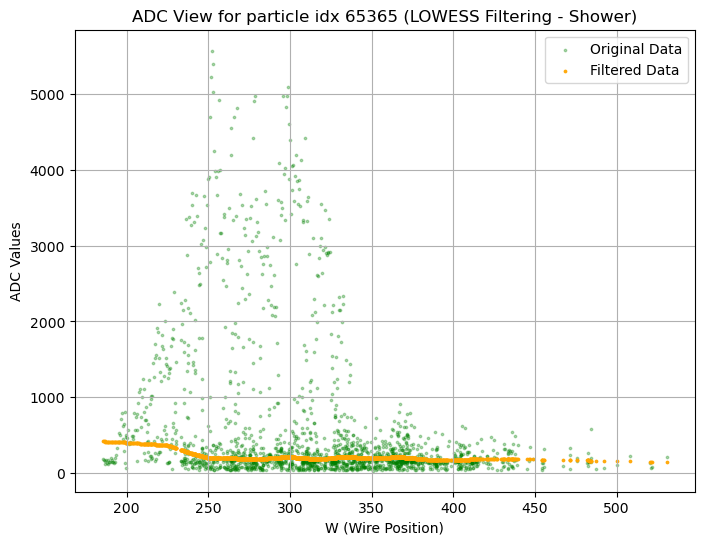

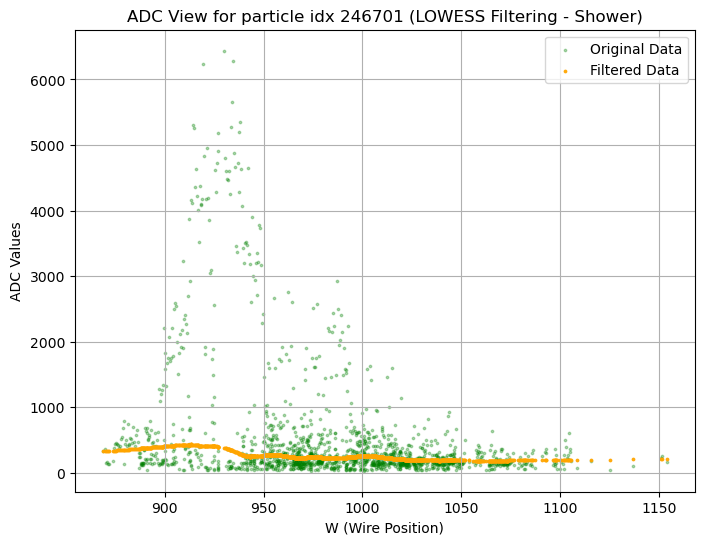

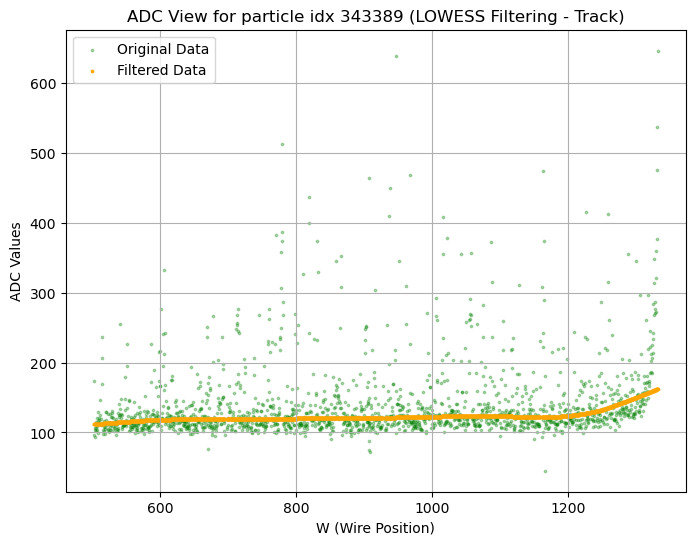

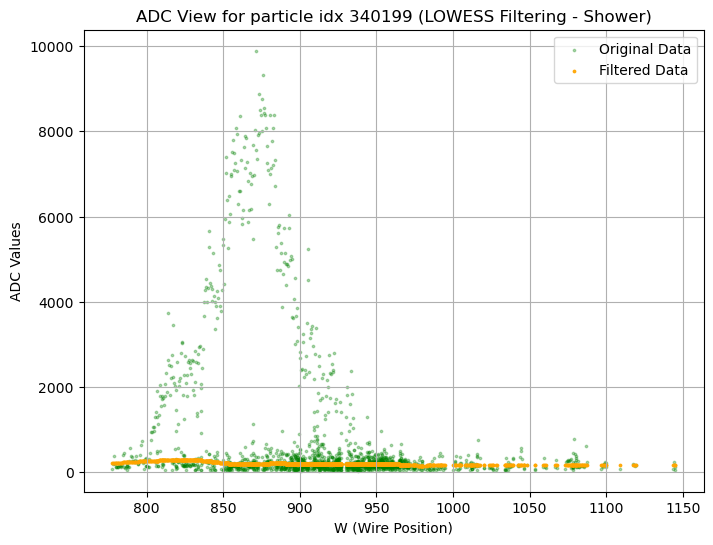

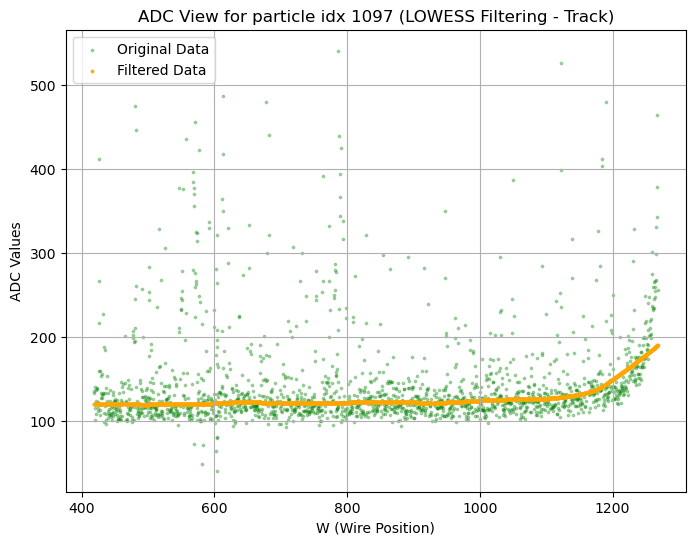

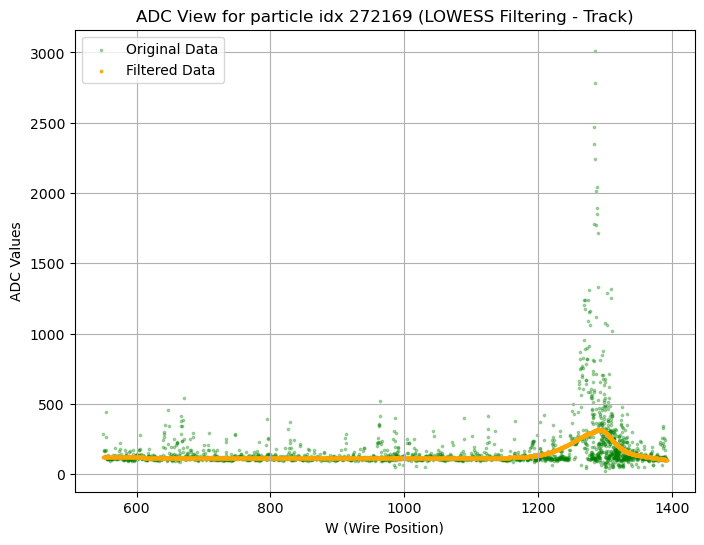

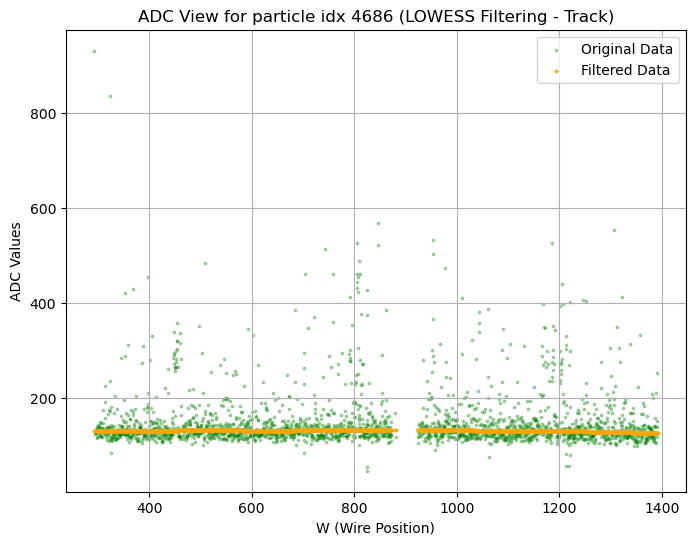

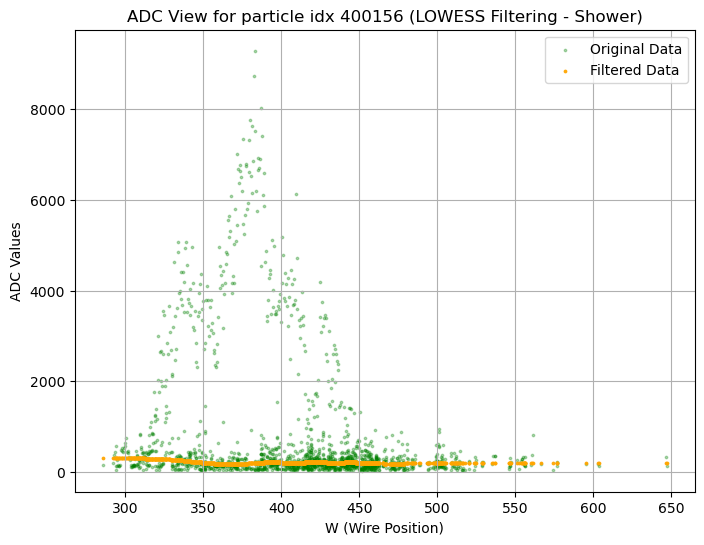

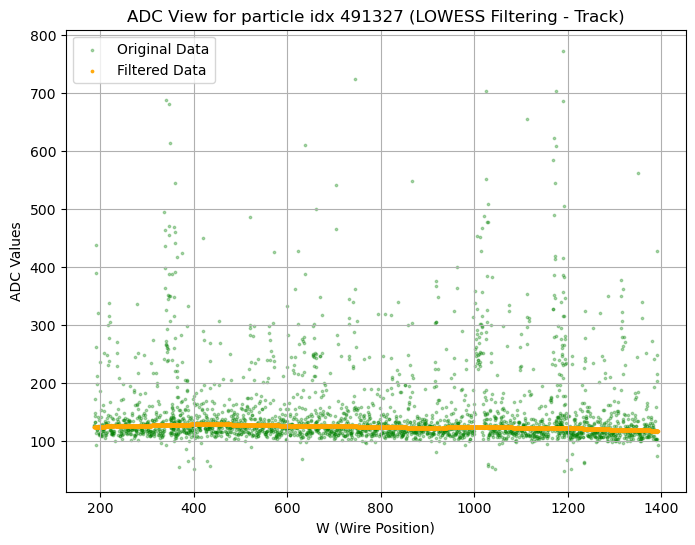

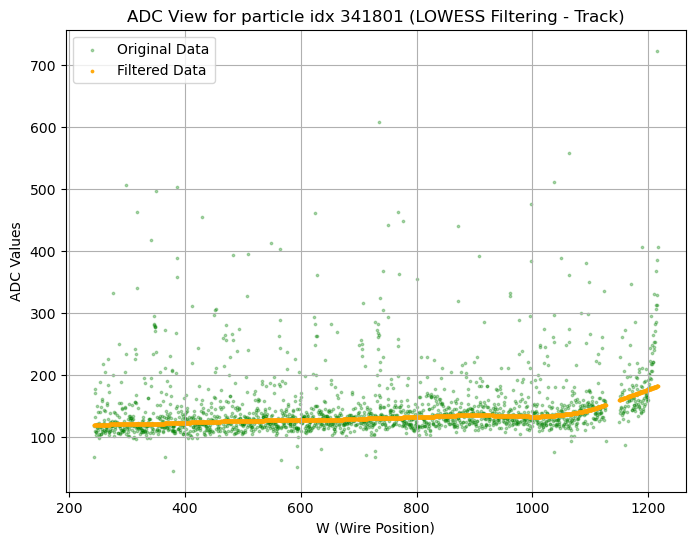

In [6]:
# have a look at 10 random indices for the LOWESS model

for _ in range(10):
    sample_idx2 = random.choice(sample_array)
    adc_profile_idx_filtered_7(cheated_0, sample_idx2, True)

In [13]:
# find a percentage for tracks that escape the detector.

def truncations(events, hits_cutoff):
    event_size = len(events.num_final_state_particles)

    full = 0
    partial = 0

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            if max(events.reco_hits_w[i]) > 1370:
                partial += 1
            else: full += 1

    return partial / (full + partial)

print(truncations(cheated_0,15))

0.0828806835520293


In [ ]:
def var_adc_max_LOWESS(events, hits_cutoff, num_steps, show_plot):
    event_size = len(events.num_final_state_particles)

    peak_track = []
    peak_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            w_hits = events.reco_hits_w[i]
            adc_values = events.reco_adcs_w[i]
            
            frac = 0.2  # Fraction of data to use for smoothing
            smoothed = lowess(adc_values, w_hits, frac=frac)
            w_smooth, adc_smooth = smoothed[:, 0], smoothed[:, 1]

            points = np.column_stack((w_smooth, adc_smooth))
        
            # find the boundaries for which we want to find the energies at
            steps = np.linspace(min(w_smooth), max(adc_smooth), num_steps + 1)
            midpoints = (steps[:-1] + steps[1:]) / 2
        
            avg_adc = []
        
            for s in range(len(steps) - 1):
                # Define the current interval
                start, end = steps[s], steps[s + 1]
                
                # Select the y-values within the current interval
                mask = (points[:, 0] >= start) & (points[:, 0] < end)
                y_values_in_interval = points[mask, 1]
                
                # Compute the average y-value for the interval if there are points in it
                if len(y_values_in_interval) > 0:
                    average_y = np.mean(y_values_in_interval)
                else:
                    average_y = np.nan  # Handle case with no points in the interval
                
                # Append the average to the list
                avg_adc.append(average_y)
        
            max_idx = np.argmax(avg_adc)
            location = (midpoints[max_idx] - min(steps))/(max(steps) - min(steps)) # standardise to [0,1]
    
            if events.mc_pdg[i] in [-11,11,22]:
                peak_shower.append(location)
            else: peak_track.append(location)

    bin_edges = np.linspace(0, 1, num_steps + 1)

    n_t = len(peak_track)
    n_s = len(peak_shower)

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(peak_track) / n_t if n_t > 0 else np.zeros_like(peak_track)
    shower_weights = np.ones_like(peak_shower) / n_s if n_s > 0 else np.zeros_like(peak_shower)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(peak_track, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(peak_shower, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(peak_track, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='Tracks')
    plt.hist(peak_shower, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='Showers')

    # Set plot details
    plt.title(f'Fractional Histogram of {n_t + n_s} ADC Peak Values for events above {hits_cutoff} hits, {n_t} tracks and {n_s} showers.')
    plt.xlabel('Peak Value')
    plt.ylabel('Fraction of events')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlim(0,1)
    plt.legend()
    plt.grid(False)
    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges

# bad function^

In [ ]:
# will try and quantify using a sequence.

def var_adc_Lslopes(events, hits_cutoff, show_plot): # slope of a lowess plot in the last 5%
    event_size = len(events.num_final_state_particles)

    slopes_track = []
    slopes_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            w_lowess, adc_lowess = adc_profile_idx_filtered_7(events, i, False)
    
            # Determine the number of points corresponding to the last 5%
            num_points = max(2, len(w_lowess) // 20)  # Ensure at least 2 points
        
            # Extract the last 5% of points
            w_last = w_lowess[-num_points:]
            adc_last = adc_lowess[-num_points:]
        
            # Perform linear regression on the extracted points
            slope, _ = np.polyfit(w_last, adc_last, 1)

            if events.mc_pdg[i] in [-11, 11, 22]:
                slopes_shower.append(slope)
            else: slopes_track.append(slope)

    bin_edges = np.arange(-100, 101, 2)

    n_t = len(slopes_track)
    n_s = len(slopes_shower)

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(slopes_track) / n_t if n_t > 0 else np.zeros_like(slopes_track)
    shower_weights = np.ones_like(slopes_shower) / n_s if n_s > 0 else np.zeros_like(slopes_shower)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(slopes_track, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(slopes_shower, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(slopes_track, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='tracks')
    plt.hist(slopes_shower, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='shower')
    plt.xlabel('slopes')
    plt.ylabel('fraction of events')
    plt.legend()

    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges

#lslopes = var_adc_Lslopes(cheated_0, 15, True)

            

In [ ]:
testing_idx = [] # will take ALL events with >15 hits...

for i in range(len(cheated_0.num_final_state_particles)):
    if len(cheated_0.reco_hits_w[i]) > 15:
        testing_idx.append(i)

In [ ]:
f.ROC_alt(lslopes)

In [ ]:
import random
for _ in range(20):
    adc_profile_idx_filtered_7(cheated_0, random.choice(testing_idx), True)

In [ ]:
# why not have a look at the standard deviation within the LOWESS plot?

def var_adc_Lsd(events, hits_cutoff, show_plot): # slope of a lowess plot in the last 5%
    event_size = len(events.num_final_state_particles)

    sd_track = []
    sd_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            w_lowess, adc_lowess = adc_profile_idx_filtered_7(events, i, False)
    
            # Step 1: Calculate the mean
            adc_mean = np.mean(adc_lowess)
            
            # Step 2: Compute squared differences
            squared_differences = (adc_lowess - adc_mean) ** 2
            
            # Step 3: Calculate standard deviation
            std_dev = np.sqrt(np.mean(squared_differences))  # Population

            if events.mc_pdg[i] in [-11, 11, 22]:
                sd_shower.append(std_dev)
            else: sd_track.append(std_dev)
    
    print(max(sd_shower))
    bin_edges = np.arange(0, 301, 5)

    n_t = len(sd_track)
    n_s = len(sd_shower)

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(sd_track) / n_t if n_t > 0 else np.zeros_like(sd_track)
    shower_weights = np.ones_like(sd_shower) / n_s if n_s > 0 else np.zeros_like(sd_shower)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(sd_track, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(sd_shower, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(sd_track, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='tracks')
    plt.hist(sd_shower, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='shower')
    plt.xlabel('standard deviations')
    plt.ylabel('fraction of events')
    plt.legend()

    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges


#Lsd = var_adc_Lsd(cheated_0, 15, True)

In [ ]:
# code is too long, firstly make a function for the values:

def two_arrays_Lsd(events, hits_cutoff):
    event_size = len(events.num_final_state_particles)

    sd_track = []
    sd_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            w_lowess, adc_lowess = adc_profile_idx_filtered_7(events, i, False)
    
            # Step 1: Calculate the mean
            adc_mean = np.mean(adc_lowess)
            
            # Step 2: Compute squared differences
            squared_differences = (adc_lowess - adc_mean) ** 2
            
            # Step 3: Calculate standard deviation
            std_dev = np.sqrt(np.mean(squared_differences))  # Population

            if events.mc_pdg[i] in [-11, 11, 22]:
                sd_shower.append(std_dev)
            else: sd_track.append(std_dev)

    return sd_track, sd_shower

sd_track, sd_shower = two_arrays_Lsd(cheated_0, 15)

In [ ]:
#define a helpful function that plots a histogram of tracks and showers

standard_deviation_pdf = f.feature_histogram('standard deviation', sd_track, sd_shower, np.arange(0, 301, 20))

In [ ]:
f.ROC(standard_deviation_pdf)

In [ ]:
def two_arrays_adc_ratio(events, hits_cutoff): # ratio of energy in the final 25% over total energy distributed
    event_size = len(events.num_final_state_particles)

    ratio_track = []
    ratio_shower = []

    for i in range(event_size):
        if len(events.reco_hits_w[i]) > hits_cutoff:

            adcs = events.reco_adcs_w[i]
            q4_idx = len(adcs) // 4

            adcs_q4 = adcs[-q4_idx:]

            ratio = sum(adcs_q4) / sum(adcs)

            if events.mc_pdg[i] in [-11, 11, 22]:
                ratio_shower.append(ratio)
            else: ratio_track.append(ratio)
                
    return ratio_track, ratio_shower

r_track, r_shower = two_arrays_adc_ratio(cheated_0, 15)

r_pdf = f.feature_histogram('Ratio of energy in final 25% over all of event', r_track, r_shower, np.arange(0, 1.1, 0.04))

In [ ]:
f.ROC_alt(r_pdf)

In [ ]:
# f.feature_histogram() returns the track_heights, shower_heights, bin_edges as a tuple given all of the arguments.

# so extracting the data we just need to find all of the feature_histogram() lines and do something like: p_t, p_s, bins = f.feature_histogram()